In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import torch
import random
import numpy as np
from PIL import Image
from datasets import load_dataset
from diffusers import AutoencoderKL

2022-10-14 22:12:12.695851: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
vae = AutoencoderKL.from_pretrained('../vae_model')

In [4]:
vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 3),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.4.1'),
            ('_name_or_path', '../vae_model')])

In [5]:
ds = load_dataset('teticio/audio-diffusion-256')

  0%|          | 0/1 [00:00<?, ?it/s]

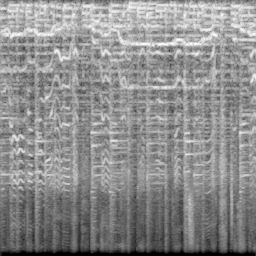

In [7]:
image = random.choice(ds['train'])['image']
image

In [11]:
# encode
input_image = np.frombuffer(image.convert('RGB').tobytes(), dtype="uint8").reshape(
    (image.height, image.width, 3))
input_image = ((input_image / 255) * 2 - 1).transpose(2, 0, 1)
latents = vae.encode(torch.tensor([input_image], dtype=torch.float32)).latent_dist.sample()

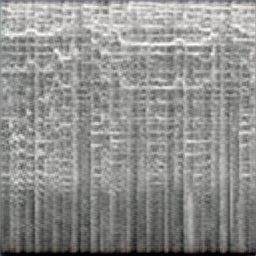

In [13]:
# decode
output_image = vae.decode(latents)['sample']
output_image = torch.clamp(output_image, -1., 1.)
output_image = (output_image + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
output_image = (output_image.detach().cpu().numpy() *
                255).round().astype("uint8").transpose(0, 2, 3, 1)[0]
Image.fromarray(output_image)

In [12]:
latents

tensor([[[[-2.5930e+00, -1.7283e+00, -3.6402e+00,  ..., -2.5861e+00,
           -3.1459e+00, -1.0318e+00],
          [-2.4231e+00, -4.7899e+00, -6.2406e+00,  ..., -7.1454e+00,
           -5.9106e+00, -4.1793e+00],
          [-2.9896e+00, -5.8155e+00, -7.9317e+00,  ..., -5.5414e+00,
           -5.6294e+00, -2.4182e+00],
          ...,
          [-6.5948e-01, -5.9849e-01, -9.5139e-01,  ...,  2.0617e+00,
           -1.3945e+00, -1.0137e+00],
          [-8.4291e-01,  1.3487e+00,  3.0778e+00,  ...,  3.4672e-01,
            1.0537e+00, -4.3472e-01],
          [-5.0941e-01,  1.0762e-01, -3.0224e-01,  ...,  1.6669e+00,
            1.2937e+00, -8.2453e-01]],

         [[-3.3128e-01,  9.2456e-02, -1.3289e-01,  ...,  5.1540e-01,
            1.3166e-01, -7.9131e-01],
          [ 2.3325e-01,  7.1368e-01,  7.8702e-01,  ...,  9.9718e-01,
            5.4440e-01,  2.9425e-01],
          [ 2.9543e-01,  1.0873e+00,  7.9517e-01,  ...,  7.4579e-01,
            4.1816e-01,  2.4818e-01],
          ...,
     